# Predicting survivors on Titanic - Kaggle competition

The sinking of the RMS Titanic is one of the most infamous shipwrecks in history.  On April 15, 1912, during her maiden voyage, the Titanic sank after colliding with an iceberg, killing 1502 out of 2224 passengers and crew. This sensational tragedy shocked the international community and led to better safety regulations for ships.

## Description of the files

We have two files: a training dataset and a test dataset. Both of these are csv files. Let us first consider the training data and look at its contents. We will use csv, numpy, and pandas libraries for reading the data and analysis.

## Reading the training dataset, and initial analysis

In [1]:
# csv, numpy, and pandas packages are imported

import numpy as np
import pandas as pd

We will now read the entire dataset and subsequently start digging deeper into the data. For reading the data we use the read_csv function in pandas.

In [229]:
# Since we know row 0 is the header row, we will pass the argument header = 0
data = pd.read_csv('train.csv', header=0)

Let us now look at the datatypes for each column using the DataFrame.dtypes attribute. Subsequently, we look at the summary of certain columns in the dataset. The summary function in pandas give us statistical information about the data such as mean, percentiles, minimum and maximum values of each column.

In [230]:
data.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

The data types of all 12 columns are shown above. Those that contain numeric data are as follows: 1) PassengerId is the unique Id corresponding to each passenger, 2) Survived is a variable that takes binary values with 1 indicating that the passenger survived, 3) Pclass is the reservation class, 4) Age is the age of the passenger, 5) Sibsp tells us the number of siblings/spouses the passenger had, 6) Parch tells us the number of parents/childred with the passenger, 7) Fare is the total ticket fare paid by the passenger.

Additionally, we have the name, sex, ticket number, cabin, and port where the passenger embarked as available information.

We now look at those columns in the dataset that are numeric and might hold information (i.e be the predictor variables) for probability of survival. Columns such as Name, PassengerId, Cabin, and Embarked are excluded from this analysis since these either contain string data or are unique identifiers that do not tell us about the likelihood of survival. We should also compare the overall data with that of the survivors.

In [231]:
data[['Pclass','Age','SibSp','Parch','Fare']].describe()

,Pclass,Age,SibSp,Parch,Fare
count,891.000000,714.000000,891.000000,891.000000,891.000000
mean,2.308642,29.699118,0.523008,0.381594,32.204208
std,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,2.000000,20.125000,0.000000,0.000000,7.910400
50%,3.000000,28.000000,0.000000,0.000000,14.454200
75%,3.000000,38.000000,1.000000,0.000000,31.000000
max,3.000000,80.000000,8.000000,6.000000,512.329200


In [232]:
data[data['Survived'] == 1][['Pclass','Age','SibSp','Parch','Fare']].describe()

,Pclass,Age,SibSp,Parch,Fare
count,342.000000,290.000000,342.000000,342.000000,342.000000
mean,1.950292,28.343690,0.473684,0.464912,48.395408
std,0.863321,14.950952,0.708688,0.771712,66.596998
min,1.000000,0.420000,0.000000,0.000000,0.000000
25%,1.000000,19.000000,0.000000,0.000000,12.475000
50%,2.000000,28.000000,0.000000,0.000000,26.000000
75%,3.000000,36.000000,1.000000,1.000000,57.000000
max,3.000000,80.000000,4.000000,5.000000,512.329200


We notice that in the data summary, the total count of passengers whose age was recorded is less than the total number of passengers (this is also true for the subset of passengers who survive).

While the median passenger class for all passengers is 3, for the survivors it is 2. This indicates that higher class passengers are more likely to survive. Age does not straightaway appear to be a strong indicator of survival probability looking at this table - however, we might have to dig deeper before drawing this conclusion. The median fare for survivors is also much greater than that of all passengers indicating that you are likely to survive if you paid a higher fare (this, of course, is correlated with the passenger class column).

Let us now look at the distribution of age among passengers that survived and those who did not.

In [233]:
import matplotlib.pyplot as plt
%matplotlib inline

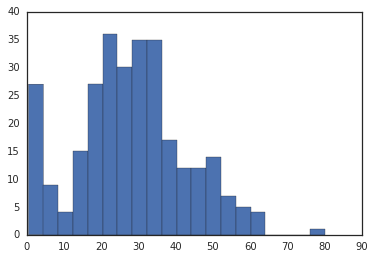

In [234]:
plt.hist(data[data['Survived'] == 1]['Age'].dropna(), bins = 20)
plt.show()

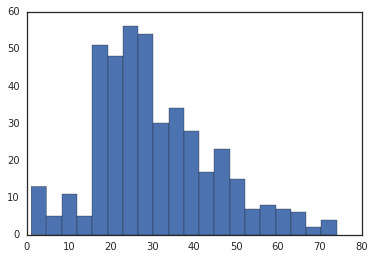

In [235]:
plt.hist(data[data['Survived'] == 0]['Age'].dropna(), bins = 20)
plt.show()

From the two age histograms of the passengers who survived and those who didn't, we notice that under the age of 15 there is a higher probability of survival than for other ages. This information might be useful for engineering a new feature, for machine learning, which checks if the age is less than 15. 

In general, there is a normal distribution of ages for all passengers. Also, since age will be an important metric for the machine learning algorithm, we will later need to fill the age column for all rows where age was not recorded. Let's look at the median age of the male and female populations, and also median ages of those who survived for each sex.

In [236]:
data[data['Sex'] == 'male']['Age'].dropna().median()

29.0

In [237]:
data[(data['Sex'] == 'male') & (data['Survived'] == 1)]['Age'].dropna().median()

28.0

In [238]:
data[data['Sex'] == 'female']['Age'].dropna().median()

27.0

In [239]:
data[(data['Sex'] == 'female') & (data['Survived'] == 1)]['Age'].dropna().median()

28.0

It appears that although the median age of female passengers was slightly less than their male counterparts, among those who survived, the median age was equal.

There is a slight difference between the median ages for the two genders. Additionally, the median age could vary based on the passenger class, with higher class passengers potentially being older (and richer). Shown below are the median ages for each passenger class and embarkment port, separated in two rows for the two sexes.

In [240]:
pd.pivot_table(data,values=['Age'],index=['Sex'],columns=['Embarked','Pclass'],aggfunc='median')

Age                                     
Embarked     C                Q           S        
Pclass       1     2      3   1   2   3   1   2   3
Sex                                                
female    37.0  22.0  14.25  33  30  20  33  29  23
male      36.5  29.5  26.00  44  57  27  42  30  25

In [241]:
data.groupby(['Embarked','Pclass'])[['PassengerId','Age']].count()

PassengerId  Age
Embarked Pclass                  
C        1                85   74
         2                17   15
         3                66   41
Q        1                 2    2
         2                 3    2
         3                72   24
S        1               127  108
         2               164  156
         3               353  290

In [242]:
data['Embarked'].unique()

array(['S', 'C', 'Q', nan], dtype=object)

It seems some of the rows contain no values for the 'Embarkment' column, just like for the 'Age' column. This should be kept in mind since in the future, we will need to fill the age column and one way of doing it is to fill it with respect to Sex, Pclass, and Embarkment. For that, we first need to fill the Embarkment column.

At any rate, for now, let's continue to analyze our data. If we look at the total number of survivors and deceased irrespective of any classification, we get an average percentage of deceased = 61.6%. 

In [243]:
grouped = data.groupby(['Survived'])
grouped['PassengerId'].count()

Survived
0    549
1    342
Name: PassengerId, dtype: int64

Next, we look at the survivor count based on the sex of the passenger. Here, we clearly observe, as shown below, that female passengers have a higher probability of survival.

        Deceased  Survived
Sex                       
female        81       233
male         468       109


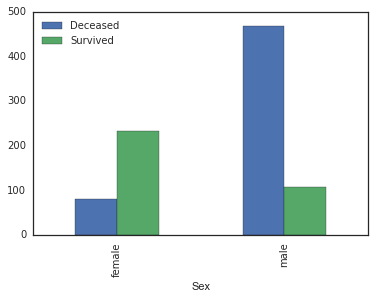

In [244]:
df = pd.pivot_table(data, index=['Sex'],columns=['Survived'], aggfunc = 'size')
df.columns = ['Deceased','Survived']
print df
df.plot.bar()

If we look at the survivor count based on the passenger class, we also observe, as shown below, that Pclass 1 has a higher probability of survival, Pclass 2 is lower, while Pclass 3 has the least probability of survival.

        Deceased  Survived
Pclass                    
1             80       136
2             97        87
3            372       119


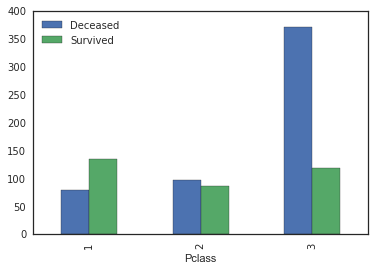

In [245]:
df = pd.pivot_table(data, index=['Pclass'],columns=['Survived'], aggfunc = 'size')
df.columns = ['Deceased','Survived']
print df
df.plot.bar()

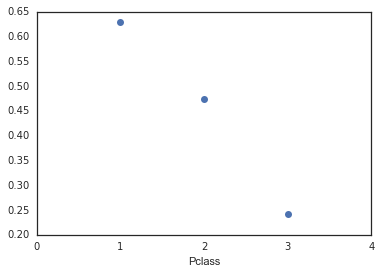

In [246]:
df['Survival_rate'] = df['Survived']/(df['Survived']+df['Deceased'])
df.Survival_rate.plot(style = 'o', xticks=[0, 1, 2, 3, 4])

We can similarly also look at how the number of siblings/spouse or parents/children affect the survival probability. It appears that for both 1 sibling/spouse or 1 parent/child the probability of survival goes slightly up. It is, however, possible that this is due to the fact that most women who were traveling had either an accompanying husband or a guardian (parent) with them. Thus, if the probability of survival for females is greater, it automatically increases the probability of survival for someone traveling with a spouse/parent. It might be a good idea, therefore, to couple these features with the sex and age features to derive new features.

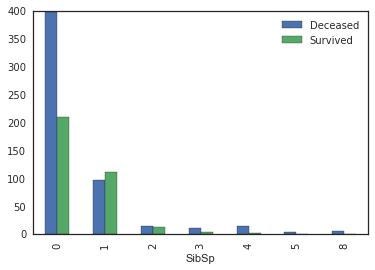

In [247]:
df = pd.pivot_table(data, index=['SibSp'],columns=['Survived'], aggfunc = 'size')
df.columns = ['Deceased','Survived']
df.plot.bar()

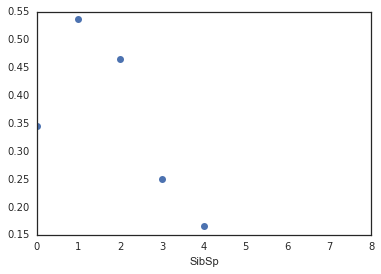

In [248]:
df['Survival_rate'] = df['Survived']/(df['Survived']+df['Deceased'])
df.Survival_rate.plot(style = 'o', xticks=[0, 1, 2, 3, 4, 5, 6, 7, 8])

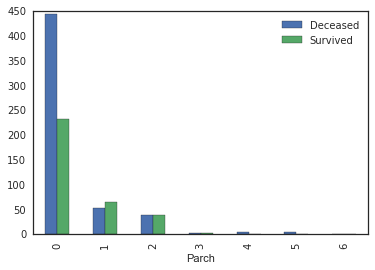

In [249]:
df = pd.pivot_table(data, index=['Parch'],columns=['Survived'], aggfunc = 'size')
df.columns = ['Deceased','Survived']
df.plot.bar()

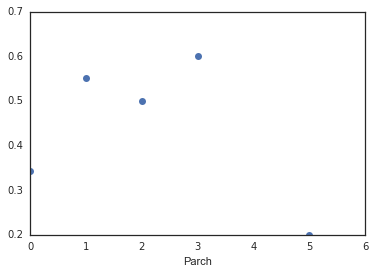

In [250]:
df['Survival_rate'] = df['Survived']/(df['Survived']+df['Deceased'])
df.Survival_rate.plot(style = 'o', xticks=[0, 1, 2, 3, 4, 5, 6], ylim = [0.2,0.7])

## Feature Engineering and Data munging

As discussed above, we shall go ahead and define new features, ensure that no row contains null values, and remove columns that do not contain numeric data that can be used by a machine learning algorithm.

In [251]:
# Engineering a new Gender feature which assigns 0 or 1 depending on whether the passenger
# is a male or female
data['Gender'] = 0
data['Gender'] = np.where(data['Sex']=='female', 1, 0)

In [252]:
median_ages = np.zeros((2,3))

In [253]:
for i in range(0, 2):
    for j in range(0, 3):
        median_ages[i,j] = data[(data['Gender'] == i) & \
                              (data['Pclass'] == j+1)]['Age'].dropna().median()

In [254]:
median_ages

array([[ 40. ,  30. ,  25. ],
       [ 35. ,  28. ,  21.5]])

In [255]:
data['Age_null_removed'] = data['Age']

In [256]:
for i in range(0, 2):
    for j in range(0, 3):
        data.loc[(data.Age.isnull()) & (data.Gender == i) & (data.Pclass == j+1),\
                'Age_null_removed'] = median_ages[i,j]


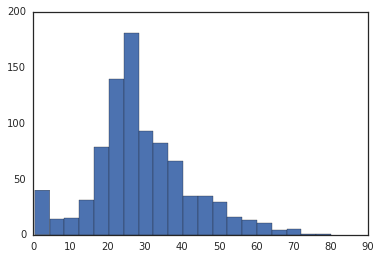

In [257]:
plt.hist(data['Age_null_removed'], bins=20)
plt.show()

In [258]:
from scipy import stats
print stats.jarque_bera(data['Age_null_removed'])

(60.73772015607441, 6.4726002335646626e-14)


In [259]:
# Engineering a new feature Age_Class which combines Age and Pclass - two important features for prediction 
# Engineering a second feature 'Family' which is the sum of 'SibSp and 'Parch'
# Adding an 'Embarked_Class' feature which maps the 'Embarked' class to an equivalent integer value.

data['Age_Class'] = data['Age_null_removed']*data['Pclass']
#data['Family'] = data['SibSp'] + data['Parch']
data['Age_less_than_15'] = np.where(data.Age_null_removed <= 15,1,0)
data['Embarked_Class'] = data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(float)
data[data['Embarked_Class'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Age_null_removed,Age_Class,Age_less_than_15,Embarked_Class
61,62,1,1,"Icard, Miss. Amelie",female,38,0,0,113572,80,B28,NaN,1,38,38,0,NaN
829,830,1,1,"Stone, Mrs. George Nelson (Martha Evelyn)",female,62,0,0,113572,80,B28,NaN,1,62,62,0,NaN


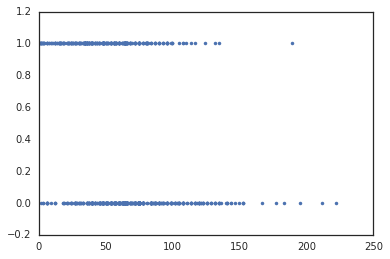

In [260]:
# create a matplotlib figure
plt.figure()
# generate a scatterplot inside the figure
plt.plot(data.Age_Class, data.Survived, '.')
plt.ylim([-0.2,1.2])
# show the plot
plt.show()

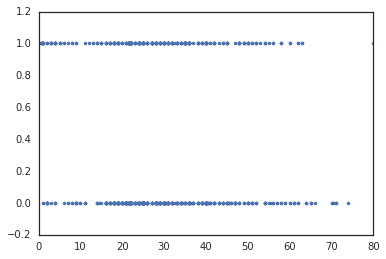

In [261]:
# create a matplotlib figure
plt.figure()
# generate a scatterplot inside the figure
plt.plot(data.Age_null_removed, data.Survived, '.')
plt.ylim([-0.2,1.2])
# show the plot
plt.show()

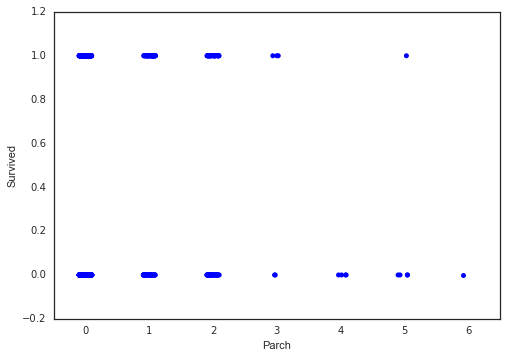

In [262]:
import seaborn as sns
# create a seaborn figure
sns.set(style='white',color_codes=False)
sns.stripplot(x=data.Parch, y=data.Survived, jitter=True, color='blue')

In [263]:
data.loc[data['Embarked_Class'].isnull(), 'Embarked_Class'] = 0
data[data['Embarked_Class'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Age_null_removed,Age_Class,Age_less_than_15,Embarked_Class


In [264]:
#define an array of all Embarked_ports
Embarked_ports = [0, 1, 2]

#make a column for each embarked port and populate it with true or false
for port in Embarked_ports:
    data[port] = [port == emb_port for emb_port in data['Embarked_Class']]
         
data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Age_null_removed,Age_Class,Age_less_than_15,Embarked_Class,0,1,2
0,1,0,3,"Braund, Mr. Owen Harris",male,22,1,0,A/5 21171,7.2500,NaN,S,0,22,66,0,0,True,False,False
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38,1,0,PC 17599,71.2833,C85,C,1,38,38,0,1,False,True,False
2,3,1,3,"Heikkinen, Miss. Laina",female,26,0,0,STON/O2. 3101282,7.9250,NaN,S,1,26,78,0,0,True,False,False
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35,1,0,113803,53.1000,C123,S,1,35,35,0,0,True,False,False
4,5,0,3,"Allen, Mr. William Henry",male,35,0,0,373450,8.0500,NaN,S,0,35,105,0,0,True,False,False


In [483]:
training_data = data.drop(data[['PassengerId','Pclass','Name', 'Sex','Age','Ticket','Cabin', 'Embarked',
                                'Age_Class','Age_null_removed','Embarked_Class']], axis=1)

In [484]:
training_data.head()

,Survived,SibSp,Parch,Fare,Gender,Age_less_than_15,0,1,2
0,0,1,0,7.2500,0,0,True,False,False
1,1,1,0,71.2833,1,0,False,True,False
2,1,0,0,7.9250,1,0,True,False,False
3,1,1,0,53.1000,1,0,True,False,False
4,0,0,0,8.0500,0,0,True,False,False


In [436]:
#training_data = training_data.astype(float)
#training_data.dtypes

## Training the data with a machine learning model (logistic regression/Random Forests)

Before training the classifier algorithm, we need to ensure that all the input variable are floats. This was accomplished in the last step. The columns that act as predictors are defined within the variable 'cols' while 'colsRes' defines the outcome.

In [485]:
cols = ["SibSp", "Parch", "Fare", "Gender", "Age_less_than_15", 0, 1, 2]

from sklearn import preprocessing
from sklearn import cross_validation

# training_data_normalized = pd.DataFrame(preprocessing.normalize(training_data[cols], norm='l2', axis=1, copy=True))

# trainArr = training_data_normalized.as_matrix([0,1,2,3,4,5,6,7]) #training array
colsRes = ['Survived']
trainRes = training_data.as_matrix(colsRes) # training results

trainArr = training_data.as_matrix(cols) #training array

# training_data_normalized.head()
training_data[cols].head()

,SibSp,Parch,Fare,Gender,Age_less_than_15,0,1,2
0,1,0,7.2500,0,0,True,False,False
1,1,0,71.2833,1,0,False,True,False
2,0,0,7.9250,1,0,True,False,False
3,1,0,53.1000,1,0,True,False,False
4,0,0,8.0500,0,0,True,False,False


In [499]:
# Import the linear model package from scikit-learn
from sklearn import linear_model, datasets

# Also import the random forest package
from sklearn.ensemble import RandomForestClassifier

# forest = RandomForestClassifier(n_estimators = 200)

# Fit the training data to the Survived labels and create the decision trees

logreg = linear_model.LogisticRegression(C=15)

forest = RandomForestClassifier(random_state=1, n_estimators=150, min_samples_split=4, min_samples_leaf=2)

scores = cross_validation.cross_val_score(forest, trainArr, trainRes.ravel(), cv=3)
print scores.mean()

forest = forest.fit(trainArr, trainRes) # fit the data to the algorithm

# logreg.fit(trainArr, trainRes)

0.810325476992


C:\Users\Anirban\Anaconda2\lib\site-packages\ipykernel\__main__.py:18: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


## Applying the model on test data

Having trained the random forest classifer model, we read in the test dataset. We then perform the same feature engineering and data munging steps on this dataset. All the variables are converted to float before the predict step is performed. Finally, we write the outcome on a csv file having first converted the outcome file variables ('PassengerId' and 'Survived') to integers.

In [456]:
test_data = pd.read_csv('test.csv', header=0)

# We perform the same feature engineering steps on the test data as we did on the training data
test_data['Gender'] = 0
test_data['Gender'] = np.where(test_data['Sex']=='female', 1, 0)
test_data['Age_null_removed'] = test_data['Age']

for i in range(0, 2):
    for j in range(0, 3):
        test_data.loc[(test_data.Age.isnull()) & (test_data.Gender == i) & (test_data.Pclass == j+1),\
                'Age_null_removed'] = median_ages[i,j]

test_data['Age_Class'] = test_data['Age_null_removed']*test_data['Pclass']
test_data['Age_less_than_15'] = np.where(test_data.Age_null_removed <= 15, 1, 0)
#test_data['Family'] = test_data['SibSp'] + test_data['Parch']
test_data['Embarked_Class'] = test_data['Embarked'].map( {'S': 0, 'C': 1, 'Q': 2} ).astype(float)
#define an array of all Embarked_ports
Embarked_ports = [0, 1, 2]

#make a column for each embarked port and populate it with true or false
for port in Embarked_ports:
    test_data[port] = [port == emb_port for emb_port in test_data['Embarked_Class']]
         
test_data.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Gender,Age_null_removed,Age_Class,Age_less_than_15,Embarked_Class,0,1,2
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q,0,34.5,103.5,0,2,False,False,True
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S,1,47.0,141.0,0,0,True,False,False
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q,0,62.0,124.0,0,2,False,False,True
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S,0,27.0,81.0,0,0,True,False,False
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S,1,22.0,66.0,0,0,True,False,False


In [481]:
ids = test_data['PassengerId']
test_data_modified = test_data.drop(data[['PassengerId','Pclass','Name', 'Sex','Age','Ticket','Cabin', 'Embarked',
                                'Age_Class','Age_null_removed','Embarked_Class']], axis=1)

In [482]:
test_data_modified[test_data_modified.Fare.isnull()] #There is one row in the test dataset that has no fare information

,SibSp,Parch,Fare,Gender,Age_less_than_15,0,1,2
152,0,0,NaN,0,0,True,False,False


In [487]:
test_data_modified.loc[test_data_modified.Fare.isnull(), 'Fare'] = 7.5

In [488]:
test_data_modified[test_data_modified.Fare.isnull()]

,SibSp,Parch,Fare,Gender,Age_less_than_15,0,1,2


In [489]:
#test_data[test_data['Embarked_Class'].isnull()]

In [490]:
ids = ids.values
test_data_modified = test_data_modified.astype(float)

# test_data_normalized = pd.DataFrame(preprocessing.normalize(test_data_modified))

In [500]:
output = forest.predict(test_data_modified)
# output = logreg.predict(test_data_modified)
output_file = zip(ids, output)
output_file = pd.DataFrame(output_file, columns=['PassengerId','Survived'])
output_file = output_file.astype(int)

In [501]:
output_file.to_csv('RF_predictions_with_age-less-than-15-column.csv', index=False)

#### My output file had a 77.512% accuracy with the Random Forest Classifier, and a 76.55% accuracy with the logistic regression model, when I submitted to Kaggle.
#### It should be noted,however, that the cross validation test results in much higher accuracy of 81.03% and 79.1% respectivel

In [468]:
import numpy as np
import pandas as pd

#Print you can execute arbitrary python code
train = pd.read_csv("train.csv", dtype={"Age": np.float64}, )

train['Sex'] = train['Sex'].replace('male', 1).replace('female', 0)

train = train[np.isfinite(train['Age'])]

from sklearn.tree import DecisionTreeClassifier
X = train.filter(['Pclass', 'Sex', 'Age', 'Fare'])
y = train[['Survived']]
clf = DecisionTreeClassifier(random_state=241)
clf.fit(X, y)

importances=clf.feature_importances_

print(importances)

[ 0.14000522  0.30051221  0.2560461   0.30343647]
